In [2]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch import optim

from PIL import Image
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import seaborn as sns


## Load the data

 [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing.
The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
#data_transforms = t
 

train_transform = transforms.Compose([transforms.RandomRotation(50),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 64)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64)

### Label mapping


In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


In [10]:
# TODO: Build and train your network
# Using the VGG Architecture
#model = models.vgg16(pretrained=True)

# Building the network

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(256, 102),
    nn.Softmax(dim=1)
)

model.classifier = classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0025)

model.to(device)

## Training the network

epochs = 8
steps = 0
print_every = 10
train_loss = 0

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if steps%print_every == 0:
            valid_loss = 0
            valid_accuracy = 0
            
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    # Calculating the batch loss accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(top_class.shape)
                    valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Train loss: {train_loss/print_every:.3f}, "
                  f"Valid loss: {valid_loss/len(validloader):.3f}, "
                  f"Valid accuracy: {valid_accuracy/len(validloader):.3f}")
            
            train_loss = 0
            model.train()

Epoch 1/8, Train loss: -0.045, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.023, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.023, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.022, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.019, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.027, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.016, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.016, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.025, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 1/8, Train loss: -0.025, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 2/8, Train loss: -0.025, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 2/8, Train loss: -0.020, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 2/8, Train loss: -0.016, Valid loss: -0.019, Valid accuracy: 0.019
Epoch 2/8, Train loss: -0.016, Valid loss: -0.019, 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
# TODO: Do validation on the test set
# Testing on the network
test_loss = 0
test_accuracy = 0

model.eval() # Just evaluate and not train the model
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()
        
        # Calculate the accuracy of the test set
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        

print(f"Test Loss: {test_loss/len(testloader): .3f},"
      f"Test accuracy: {test_accuracy/len(testloader): .3f}"
     )

running_loss = 0

Test Loss: -0.018,Test accuracy:  0.018


## Save the checkpoint


In [13]:
# TODO: Save the checkpoint 
# Saving the checkpoint
checkpoint = {
    'epochs': epochs,
    'learning_rate': 0.0025,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
    'class_to_idx': train_data.class_to_idx
}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint


In [15]:


# Writing a function that will rebuild the model
def load_checkpoint(filepath):
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    classifier = nn.Sequential(
        nn.Linear(25088, 512),
        nn.ReLU(), 
        nn.Dropout(p=0.2),
        nn.Linear(512, 256),
        nn.ReLU(), 
        nn.Dropout(p=0.2),
        nn.Linear(256, 102),
        nn.LogSoftmax(dim=1)
        
    )
    
    model.classifier = classifier
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    epochs = checkpoint['epochs']
    learning_rate = checkpoint['learning_rate']
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model, epochs, learning_rate

model, epochs, learning_rate = load_checkpoint('checkpoint.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification



## Image Preprocessing


In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image = Image.open(image)
    
    return test_transform(image)


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

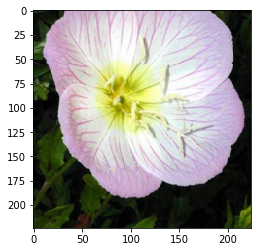

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image('flowers/test/1/image_06743.jpg'))

## Class Prediction



In [19]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    with torch.no_grad():
        logps = model.forward(process_image(image_path).unsqueeze(0))
        ps = torch.exp(logps)
        probs, labels = ps.topk(topk, dim=1)
        
        class_to_idx_inv = {model.class_to_idx[i] : i for i in model.class_to_idx}
        classes = list()
        
        for label in labels.numpy()[0]:
            classes.append(class_to_idx_inv[label])
            
        return probs.numpy()[0], classes

probs, classes = predict('flowers/test/15/image_06369.jpg', model)
print(probs)
print(classes)

[ 1.  0.  0.  0.  0.]
['89', '4', '39', '40', '38']


## Sanity Checking


In [20]:

image_path = 'flowers/test/1/image_06743.jpg'
image_class = '1'

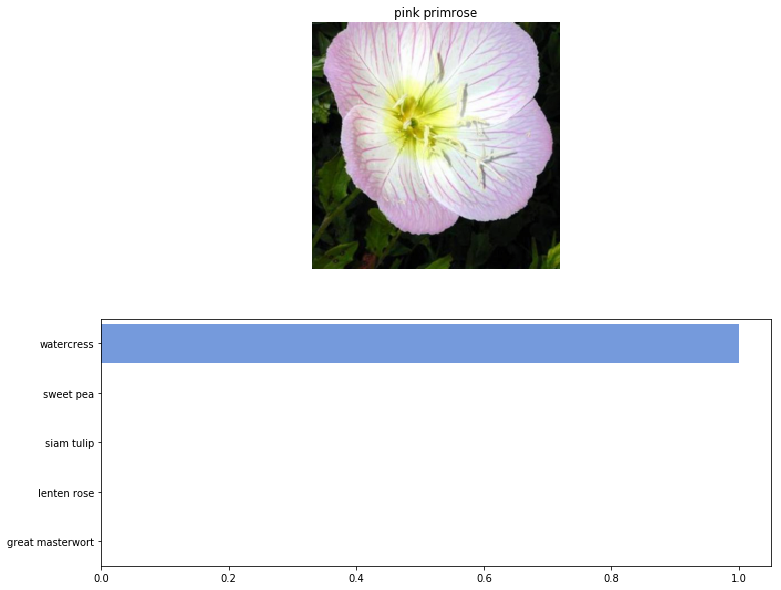

In [21]:
predict_probs, predict_classes = predict(image_path, model)

classes = []
for predict_class in predict_classes:
    classes.append(cat_to_name[predict_class])

fig = plt.figure(figsize=(12, 10))

# Plotting the image
ax = plt.subplot(2, 1, 1)
ax.set_title(cat_to_name[image_class])
plt.axis('off')
imshow(process_image(image_path), ax, title='lol')

# Plotting the probabilities
plt.subplot(2, 1, 2)
sns.barplot(x=predict_probs, y=classes, color="cornflowerblue")
plt.show()

In [2]:
# remove .pth files or move it to a temporary `~/opt` directory in this Workspace

In [ ]:
!rm. *